# Machine Learning
 
**Autori:** Erik Matovič a Simon Kokavec   
**Číslo datasetu:** 165  
**Percentuálny podiel:** 50/50

## 0. Importovanie

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab as py
import statsmodels.api as sm
import statsmodels.stats as sm_stats
import statsmodels.stats.api as sms
import math
from datetime import datetime, date
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## 1. Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu

### Zadanie  
   - Naimplementujte 1R algorithm (1R or OneR), ktorý je jednoduchá klasifikácia t.j. rozhodnutie na základe jedného atribútu. Môžete implementovať komplikovanejšie t.j. zahŕňajúce viacero atribútov (ich kombinácie).
   
   - Pravidlá by v tomto kroku mali byť vytvorené manuálne na základe pozorovaných závislostí v dátach. Vyhodnoťte klasifikátora pomocou metrík accuracy, precision a recall.

### Riešenie  

#### Načítanie datasetov



In [41]:
df_train = pd.read_csv('../../data/train.csv', sep=',')
df_test = pd.read_csv('../../data/test.csv', sep=',')
df_train.head()

,hemoglobin,leukocyty,etytr,weight,trombocyty,ast,alp,relationship,alt,hbver,smoker,erytrocyty,er-cv,indicator,hematokrit,sex,blood_group,age,race
0,0.240147,1.215254,-0.386530,-1.324705,1.012197,-0.085403,0.979523,1.0,-1.189322,-0.749305,1.0,-0.866056,-0.007817,1.0,-0.400413,0.0,2.0,-1.036721,4.0
1,-0.775564,-0.651757,-1.060210,-1.772392,-0.354930,0.556809,1.128525,1.0,-0.534179,1.053322,0.0,-0.461494,-0.660851,0.0,-0.982859,0.0,1.0,-0.347098,1.0
2,0.225980,0.146206,-1.423915,2.480386,2.024872,-1.036218,0.509456,3.0,-0.748730,0.590570,0.0,0.088501,-0.318734,0.0,2.696982,1.0,8.0,1.679314,1.0
3,-1.761756,-1.509458,0.289679,1.369844,0.516427,-0.677995,-1.674788,1.0,-0.993768,-0.292905,0.0,-0.324790,-2.056547,0.0,-0.025407,0.0,3.0,-1.166164,1.0
4,0.298584,-0.571938,0.519505,0.914422,-0.972209,2.060500,0.990801,3.0,-0.893681,0.048618,0.0,-0.484866,0.030176,0.0,-0.822366,0.0,3.0,1.161745,2.0


### Upravenie testovacieho datasetu na základe druhej fázy projektu  
 - `preprocessing.py` obsahuje transformery z druhej fázy projektu, potreba aplikovať na testovací dataset

In [45]:
import preprocessing

pipeline_obj2 = Pipeline([
        ('Transformer_scal', preprocessing.ScalingTransform(df_test, 'hemoglobin','leukocyty', 'etytr', 'weight', 'trombocyty','ast','alp', 'hbver','er-cv','alt', 'hematokrit','age', 'erytrocyty')),
        ('Transformer_yeo', preprocessing.PowerTransform(df_test, 'yeo-johnson', 'hemoglobin','leukocyty', 'etytr', 'weight', 'trombocyty','ast','alp', 'hbver','er-cv', 'alt','hematokrit','age', 'erytrocyty'))

])

test_final = pipeline_obj2.transform(df_test) 

 - v prieskumnej analýze údajov sme identifikovali vzťahy medzi `indicator`, s ktorými pracujeme v tejto fáze projektu, distribučný graf leukocytov a etytrov:

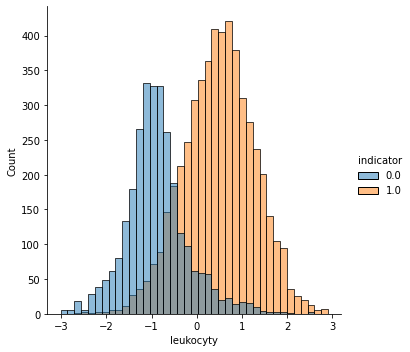

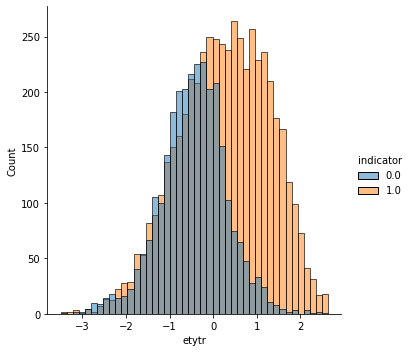

In [4]:
#Leukocyty hraničná -0.5 presnejšie -0.43 až -0,29
#Etytr hraničná -0.15

print(sns.displot(x = "leukocyty", hue = "indicator", data = df_train))
print(sns.displot(x = "etytr", hue = "indicator", data = df_train))

 - histogram a distribučný graf leukocytov a etytr chorych a zdravych pacientov:

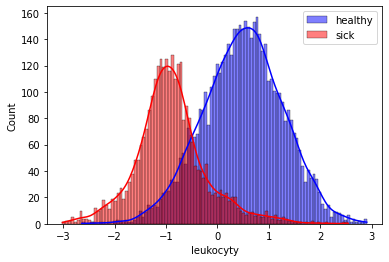

In [5]:
healthy_sample = df_train.loc[df_train.indicator == 1]
sick_sample = df_train.loc[df_train.indicator == 0]

sns.histplot(healthy_sample.leukocyty, bins=100, color='blue', kde=True, label='healthy')
sns.histplot(sick_sample.leukocyty, bins=100, color='red', kde=True, label='sick')
plt.legend()

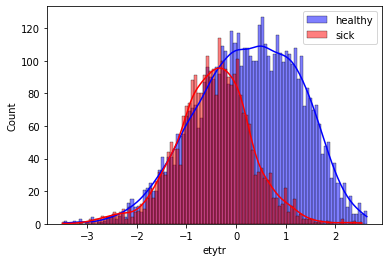

In [6]:
sns.histplot(healthy_sample.etytr, bins=100, color='blue', kde=True, label='healthy')
sns.histplot(sick_sample.etytr, bins=100, color='red', kde=True, label='sick')
plt.legend()

 - nájdeme rovnaké hodnoty etytr pre chorých a zdravých pacientov:

In [7]:
set(healthy_sample.etytr) & set(sick_sample.etytr)

{-1.1887828598149432,
 -1.0584568701074972,
 -0.95571169173116,
 -0.94698321457296,
 -0.2760184271031619,
 -0.1852133816528613,
 -0.1796479982960091,
 -0.084743904304865,
 -0.0230636675829741,
 -0.0053921223533662,
 0.0381514294825971,
 0.0530534896348707,
 0.1212574594375991,
 0.2422042115420119,
 0.3990869696657575,
 0.4844555472338493,
 0.6293536726809048}

 - nájdeme rovnaké hodnoty leukocyty pre chorých a zdravých pacientov:

In [55]:
set(healthy_sample.leukocyty) & set(sick_sample.leukocyty)

{-0.5971182626986881,
 -0.5161366108060701,
 -0.3686892126470269,
 -0.1718740656189382,
 -0.0249250306746316,
 0.0741790689681667,
 0.5949291015640512,
 0.6064474433099962}

### 1 Rule Algoritmus
 - na zaklade prienikov hodnot leukocytov sme vytvorili 1R algoritmus pre leukocyty ako náš prvý prototyp, pričom pracujeme s celkovou populaciou(total), total positive, total negative, false positive, false negative, pričom leukocyt bol vybratý ako vhodný atribút ešte z prvej fázy, z prieskumnej analýzy údajov, a hodnota -0.36 bola vybratá z hodnôt prienikov zdravých a chorých pacientov:

In [10]:
def oner_1rule(data):
    rules = dict()
    rules["total"] = data['indicator'].count()
    rules["tp"] = len(data.loc[(data.leukocyty >= -0.36) & (data['indicator'] == 1.0), 'indicator'])
    rules["tn"] = len(data.loc[(data.leukocyty < -0.36) & (data['indicator'] == 0.0), 'indicator'])
    rules["fp"] = len(data.loc[(data.leukocyty >= -0.36) & (data['indicator'] == 0.0), 'indicator'])
    rules["fn"] = len(data.loc[(data.leukocyty < -0.36) & (data['indicator'] == 1.0), 'indicator'])
    return rules
    

 - vypočet:
    - accuracy: (TP + TN) / total population
    - precision: TP / (FP + TP)
    - recall: TP / (FN + TP) 
- funkcia na výpis accuracy, precision a recall, ktore sme pocitali podla vyššie uvedených vzorcov 

In [11]:
def printer(rules):
    print("Accuracy: ",(rules["tp"] + rules["tn"]) / rules["total"])
    print("Precision: ", rules["tp"] / (rules["fp"] + rules["tp"]))
    print("Recall: ", rules["tp"] / (rules["fn"] + rules["tp"]))

 - výsledky 1R algorimu ukazuju na trénovacích dátach vyše 85% úspešnosť:

In [12]:
result = oner_1rule(df_train)
printer(result)

Accuracy:  0.8511459890383657
Precision:  0.9037487335359676
Recall:  0.861003861003861


 - výsledky 1R algorimu ukazuju na testovacích dátach porovnateľnú úspešnosť:

In [13]:
result = oner_1rule(test_final)
printer(result)

Accuracy:  0.8460388639760837
Precision:  0.8904448105436573
Recall:  0.8599840891010342


 - vizualizácia trénovacích dát:

<AxesSubplot:xlabel='etytr', ylabel='leukocyty'>

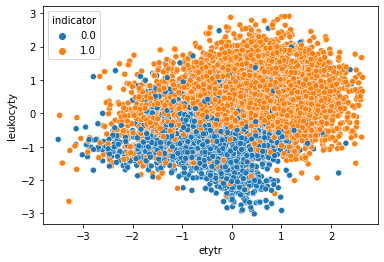

In [14]:
sns.scatterplot(y="leukocyty", x="etytr", hue="indicator", data=df_train)

 - následne sme implementovali 1R algoritmus pre výber najlepšieho parametru, inšpirovali sme sa nasledovným [zdrojom](https://github.com/mfreyeso/oner-scratch?fbclid=IwAR3CTjCs16HZqshZQCj5K9Ba-8dHGtYkj4Mu6UDLGGxnacyvkNNr_cP0yec)

In [102]:
class OneR(object):
    """
    1R implementation
    """
    
    def __init__(self):
        """
        Constructor
        """
        self.ideal_variable = None
        self.max_accuracy = 0
    
    def fit(self, dfx, y):
        """
        Find best parameter
        
        :param dfx: dataset
        :param y: target
        """
        response = list()
        result = dict()
        
        for i in dfx:
            """
            i is a column in the dataset
            """
            result[str(i)] = dict() 
            options_values = set(dfx[i])
            join_data = pd.DataFrame({"variable":dfx[i], "label":y})
            cross_table = pd.crosstab(join_data.variable, join_data.label)
            summary = cross_table.idxmax(axis=1)
            result[str(i)] = dict(summary)
            
            counts = 0
            
            for idx, row in join_data.iterrows():
                if row['label'] == result[str(i)][row['variable']]:
                    counts += 1

            accuracy = (counts/len(y))
            print(f"{i}, {accuracy}\n")
            
            if accuracy > self.max_accuracy:
                self.max_accuracy = accuracy
                self.ideal_variable = i

            result_feature = {"variable": str(i), "accuracy":accuracy, "rules": result[str(i)] }  
            response.append(result_feature)
            
        return response

    
    def predict(self, X=None):
        self_ideal_variable = self.ideal_variable + 1
        
    def __repr__(self):
        if self.ideal_variable != None:
            txt = "Najlepšia premenná pre vaše údaje je: " + str(self.ideal_variable)
        else:
            txt = "Najlepšia premenná ešte nebola nájdená"
        return txt


 - avšak ako ukazujú výstupy, tak takmer vśetky atribúty vyhodnotil s accuracy 99% a ako najlepší atribút je váha(weight), čo nekorešponduje s našími poznatkami z prieskumnej analýzy

In [103]:
#prepared_dataset = df_train.drop(['indicator'],axis='columns')
prepared_dataset = df_train.drop(['indicator'],axis='columns')

clf_custom = OneR()
clf_custom.fit(prepared_dataset, df_train['indicator'])

print(clf_custom)

hemoglobin, 0.9942700548081714

leukocyty, 0.9990034877927254

etytr, 0.9978824115595416

weight, 0.9991280518186347

trombocyty, 0.992526158445441

ast, 0.997633283507723

alp, 0.9936472346786248

relationship, 0.645241654210264

alt, 0.9885401096163428

hbver, 0.9973841554559043

smoker, 0.645241654210264

erytrocyty, 0.9966367713004485

er-cv, 0.9977578475336323

hematokrit, 0.992526158445441

sex, 0.645241654210264

blood_group, 0.645241654210264

age, 0.645241654210264

race, 0.645241654210264

Najlepšia premenná pre vaše údaje je: weight


 - z vyššie uvedených dôvodov sme sa rozhodli implementovať najlepšie vlastný 1R algoritmus rpe výber najlepšieho atribútu na základe indicator, pričom vychádzame z nášho pôvodnému algoritmu vyššie, ktorý sme testovali na leukocytoch:

In [111]:
class OneRBestAtribute(object):
    """
    1R implementation
    """
    
    def __init__(self):
        """
        Constructor
        """
        self.d_accuracy = dict()
        self.d_precision = dict()
        self.d_recall = dict()
        self.max_key = 0
    
    def fit(self, data):
        """
        Find best parameter
        
        :param data: dataset
        :param target: target
        """
        healthy_sample = data.loc[data.indicator == 1]
        sick_sample = data.loc[data.indicator == 0]

        # najdeme prieniky medzi zdravymi a chorymi pacientmi
        d_values = dict()
        for i in data:        
            d_values[str(i)] = list(
                set(healthy_sample[str(i)]) & set(sick_sample[str(i)])
            )
            
        target = data['indicator']

        # ziskame najlepssi accuracy pre kazdy atribut
        for index, (k, v) in enumerate(d_values.items()):
            #print(k)
            if (str(k) == "indicator"):
                continue
            list_accuracy = list()
            list_precision = list()
            list_recall = list()
            for i in v:
                rules = dict()
                rules["total"] = target.count()
                rules["tp"] = len(data.loc[(data[str(k)] >= round(i, 3)) & (target == 1.0), 'indicator'])
                rules["tn"] = len(data.loc[(data[str(k)] < round(i, 3)) & (target == 0.0), 'indicator'])
                rules["fp"] = len(data.loc[(data[str(k)] >= round(i, 3)) & (target == 0.0), 'indicator'])
                rules["fn"] = len(data.loc[(data[str(k)] < round(i, 3)) & (target == 1.0), 'indicator'])
                list_accuracy.append((rules["tp"] + rules["tn"]) / rules["total"])
                list_precision.append(rules["tp"] / (rules["fp"] + rules["tp"]))
                list_recall.append(rules["tp"] / (rules["fn"] + rules["tp"]))
            max_accurancy = max(list_accuracy)
            max_index = list_accuracy.index(max_accurancy) # najdi index
            self.d_accuracy[str(k)] =  list_accuracy[max_index] # save max number
            self.d_precision[str(k)] = list_precision[max_index]
            self.d_recall[str(k)] = list_recall[max_index] 
            self.max_key = max(self.d_accuracy, key=self.d_accuracy.get)

            
    def __repr__(self):
        """
        Returns representation when printing an object
        """
        txt = "Najlepší atribút pre údaje je: " + self.max_key;
        txt += "\n\ts Accuracy: " + str(self.d_accuracy[self.max_key])
        txt += "\n\ts Precision: " + str(self.d_precision[self.max_key])
        txt += "\n\ts Recall: " + str(self.d_recall[self.max_key])
        return txt

 - Ziskame najlepsi atribut z nasej implementovanej triedy:

In [113]:
oneRObject = OneRBestAtribute()
oneRObject.fit(df_train)

print(oneRObject)

Najlepší atribút pre údaje je: leukocyty
	s Accuracy: 0.8557548579970105
	s Precision: 0.881883782757311
	s Recall: 0.8965250965250965


 - algoritmus vyhodnotil najlepší atribút ako leukocyty, vizualizácia ukazuje prirodzené rozdelenie niekde medzi hodnotami -1 a 0

<AxesSubplot:xlabel='leukocyty', ylabel='leukocyty'>

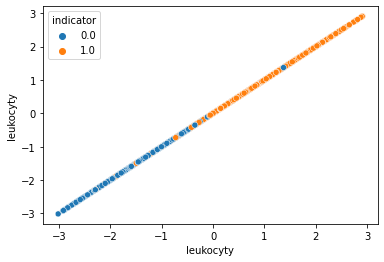

In [114]:
sns.scatterplot(y="leukocyty", x="leukocyty", hue="indicator", data=df_train)

 - obdobne najlepší atribút ukazuje aj implementácia, ktorou sme sa inšpirovali, ale až po vyhodení atribútu váhy(weight)

In [115]:
prepared_dataset = df_train.drop(['indicator'],axis='columns')
prepared_dataset = prepared_dataset.drop(['weight'],axis='columns')

clf_custom = OneR()
clf_custom.fit(prepared_dataset, df_train['indicator'])

print(clf_custom)

hemoglobin, 0.9942700548081714

leukocyty, 0.9990034877927254

etytr, 0.9978824115595416

trombocyty, 0.992526158445441

ast, 0.997633283507723

alp, 0.9936472346786248

relationship, 0.645241654210264

alt, 0.9885401096163428

hbver, 0.9973841554559043

smoker, 0.645241654210264

erytrocyty, 0.9966367713004485

er-cv, 0.9977578475336323

hematokrit, 0.992526158445441

sex, 0.645241654210264

blood_group, 0.645241654210264

age, 0.645241654210264

race, 0.645241654210264

Najlepšia premenná pre vaše údaje je: leukocyty


## 2. Natrénovanie a vyhodnotenie klasifikátora strojového učenia

### Zadanie  
   - Na trénovanie využite minimálne jeden stromový algoritm strojového učenia v scikit-learn.
   - Vizualizujte natrénované pravidlá.
   - Vyhodnoťte natrénovaný model pomocou metrík accuracy, precision a recall
   - Porovnajte natrénovaný klasifikátor s Vašimi manuálne vytvorenými pravidlami z prvého kroku.

### Riešenie 

#### DecisionTreeClassifie 

 - použijeme **DecisionTreeClassifie** s rôznymi __criterion__  
 
##### Gini
 - implementácia DecisionTreeClassifie s Gini stromu aj s  overením:

In [21]:
df_prepared = df_train.drop(columns=["indicator"])

model = tree.DecisionTreeClassifier(criterion="gini", max_depth=5)
model = model.fit(df_prepared, df_train["indicator"])

data_tree = model.predict(df_prepared)

print("Accuracy: ",accuracy_score(data_tree, df_train["indicator"]))
print("Precission: ", precision_score(data_tree, df_train["indicator"]))
print("Recall: ", recall_score(data_tree, df_train["indicator"]))


Accuracy:  0.952914798206278
Precission:  0.9664092664092664
Recall:  0.9608445297504798


Počet:
pravdivo neagtívnych [0,0]
falošne negatívnych [1,0]
pravdivo pozitívnych [1,1]
falošne pozitívnych [0,1]


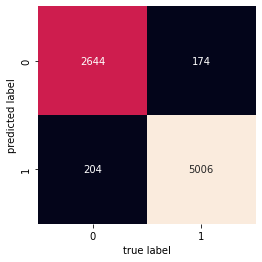

In [22]:
mat = confusion_matrix(df_train["indicator"], data_tree)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

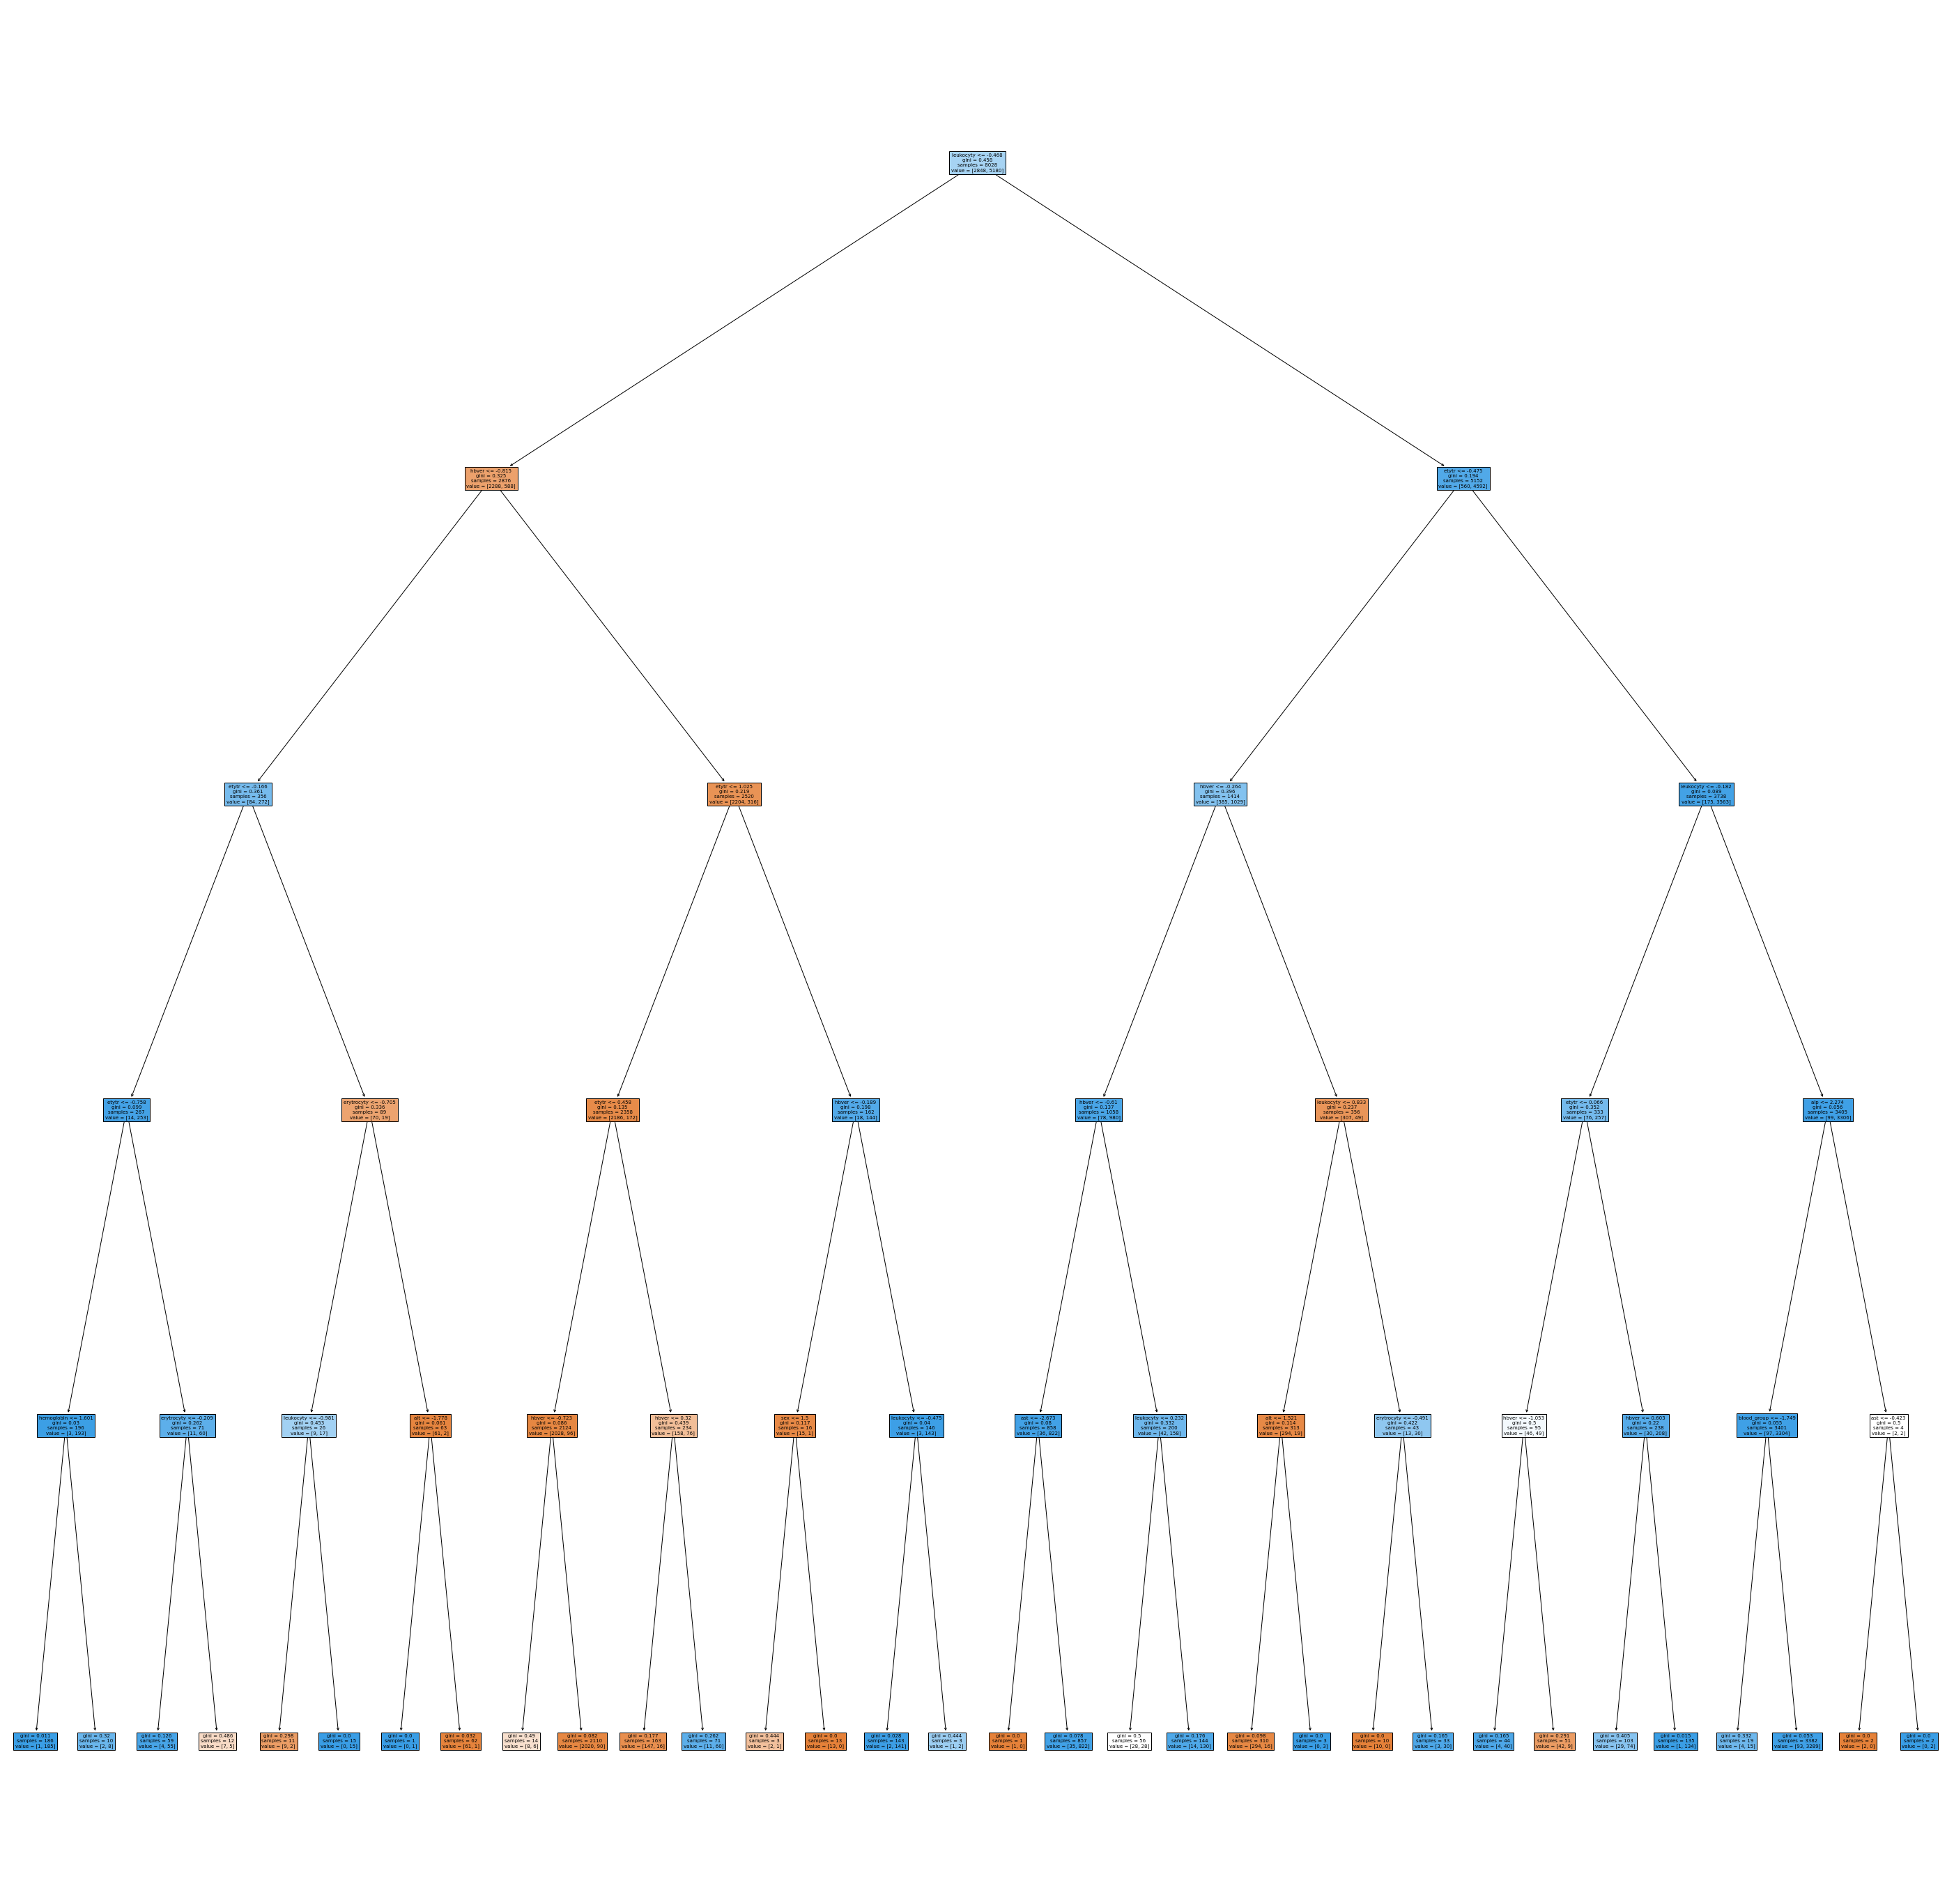

In [23]:
fig = plt.figure(figsize=(50,50))
_ = tree.plot_tree(model, feature_names=df_train.columns, filled=True)
fig.savefig('strom_gini.png')

##### Entropy
 - implementácia stromu DecisionTreeClassifie s Entropy aj s  overením:

In [24]:
df_prepared = df_train.drop(columns=["indicator"])

model = DecisionTreeClassifier(criterion="entropy", max_depth=5)
model = model.fit(df_prepared, df_train["indicator"])

data_tree = model.predict(df_prepared)

print("Accuracy: ",accuracy_score(data_tree, df_train["indicator"]))
print("Precission: ",precision_score(data_tree, df_train["indicator"]))
print("Recall: ",recall_score(data_tree, df_train["indicator"]))

Accuracy:  0.9500498256103638
Precission:  0.9698841698841699
Recall:  0.9535016132093377


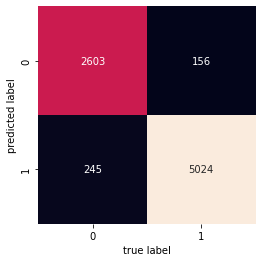

In [25]:
mat = confusion_matrix(df_train["indicator"], data_tree)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

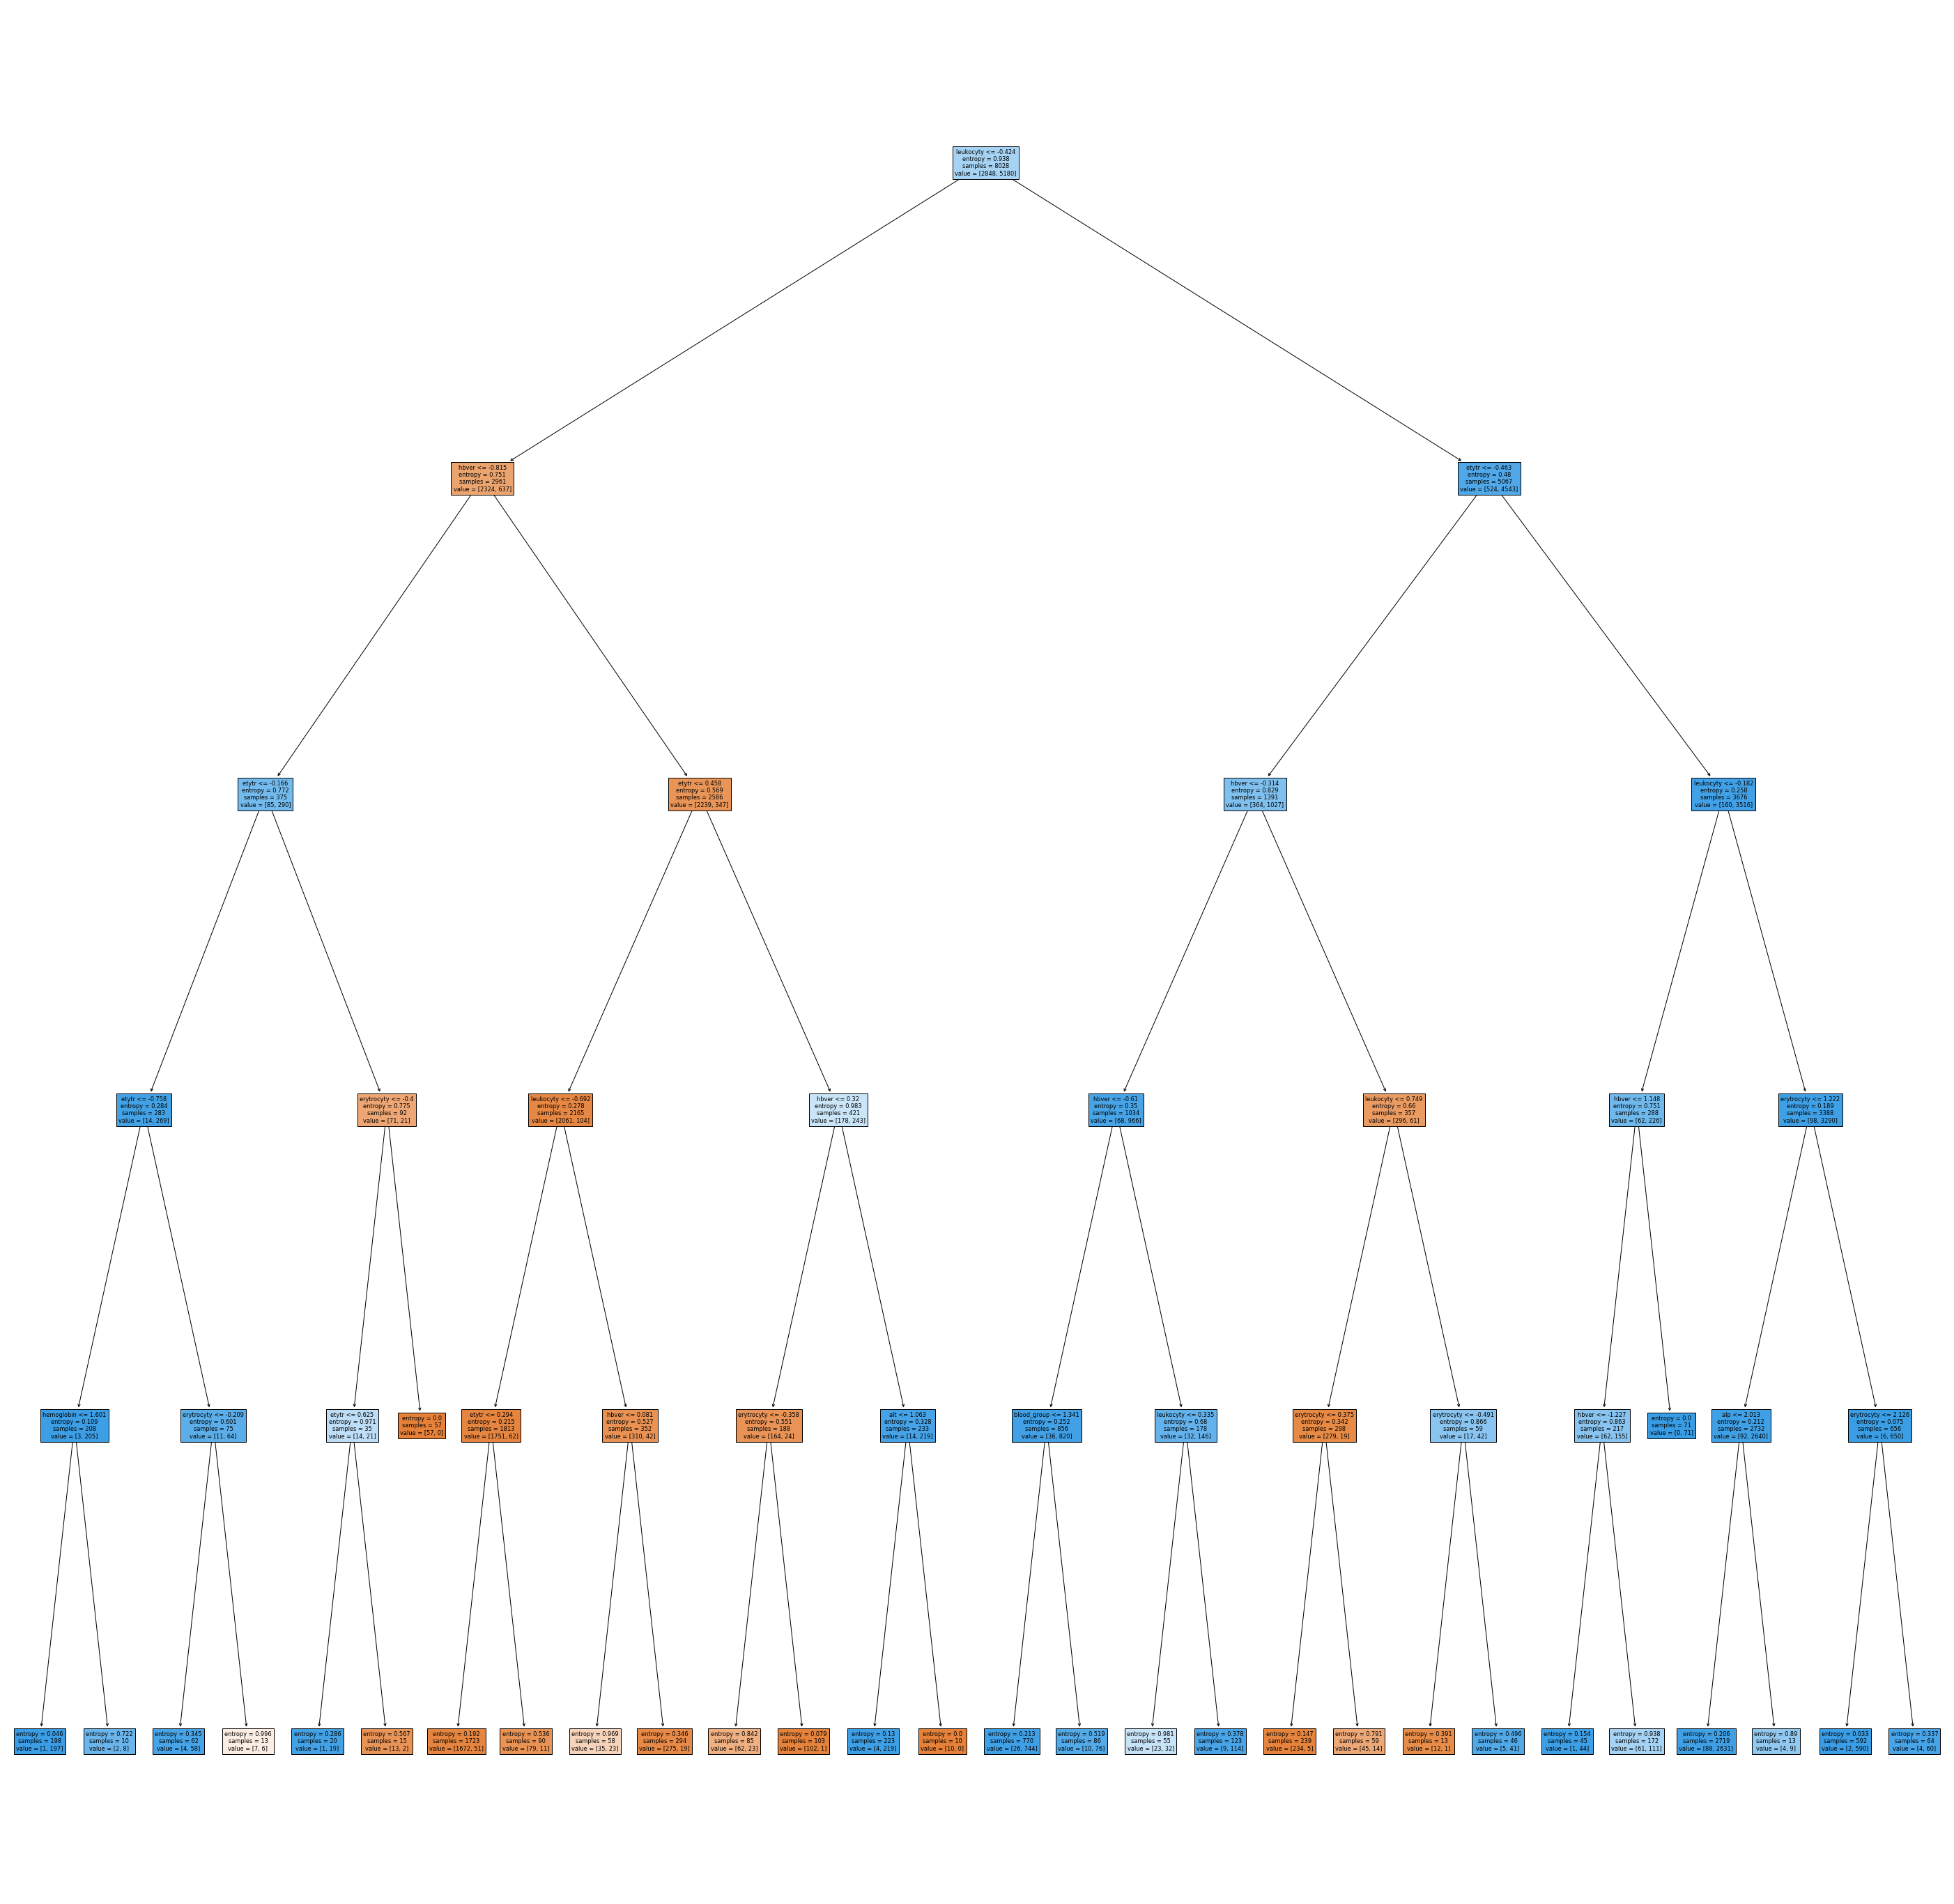

In [26]:
fig=plt.figure(figsize=(50,50))
_ = tree.plot_tree(model, feature_names=df_train.columns, filled=True)
fig.savefig('strom_entropy.png')

## 3. Optimalizácia - hyperparameter tuning

### Zadanie  
- Preskúmajte hyperparametre Vášho zvoleného klasifikačného algoritmu v druhom kroku a vyskúšajte ich rôzne nastavenie tak, aby ste minimalizovali overfitting (preučenie) a optimalizovali výsledok. 
- Vysvetlite, čo jednotlivé hyperparametre robia. Pri nastavovaní hyperparametrov algoritmu využite krížovú validáciu (cross validation) na trénovacej množine.

### Riešenie  

Hyperparameter tuning vykonáme pre stromový algoritmus **DecisionTreeClassfier** z Python modulu sklearn.

 - vytvoríme najprv rozhodovací strom **DecisionTreeClassfier**: 

In [27]:
decision_tree = tree.DecisionTreeClassifier()

 - vytvoríme si dataset a target pre naše modely:

In [28]:
df_train_no_indicator = df_train.drop(columns=["indicator"])
target = df_train.indicator

V rámci **DecisionTreeClassifier** budeme pouźívať nasledovné parametre:
 - **criterion** - funkcia pre meranie kvality rozdelenia, predvolená hodnota je Gini, ale je možnosť na výber aj Entropy
 - **splitter** - ponúka na výber hodnoty “best” a “random”, pričom predvolená hodnota je ”best”, stratégia výberu rozdelenia pre každý uzol, kde “best” stratégia vyberá najlepšie rozdelenie a “random” je stratégia pre najlepšie náhodné rozdelenie
 - **max_depth** - ako už názov napovedá jedná sa o maximalnu hĺbku stromu, predvolená hodnota je None
 - **min_samples_split** - minimálny počet vzoriek na rozdelenie uzla stromu, predvolená hodnota je 2
 - **min_samples_leaf** - minimálny počet vzoriek, ktoré musia byť v listoch stromu, predvolená hodnota je 1
 - **max_features** - zohľadňuje maximálny počet atribútov hľadaní najlepšieho rozdelenia, predvolená hodnota je None

In [29]:
parameters = {
    'criterion': ('gini','entropy'), 
    'splitter': ('best','random'), 
    'max_depth': range(2,15), 
    'max_features': range(1,10),
    'min_samples_split': range(1,10),
    'min_samples_leaf': range(1,10) 
}

# 10-nasobna cross validation
# n_jobs=-1 use all CPU & run in it parallel
optimalizationGridSearch = GridSearchCV(decision_tree, parameters, cv=10, verbose=1, n_jobs=-1)
bestFit = optimalizationGridSearch.fit(df_train_no_indicator, target)

Fitting 10 folds for each of 37908 candidates, totalling 379080 fits


## 4. Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu

### Zadanie  
Vyhodnotíte Vami zvolené stratégie riešenia projektu z hľadiska classification accuracy: 
- Stratégie riešenia chýbajúcich hodnôt a outlierov;
- Scaling resp. transformer či zlepší accuracy klasifikácie;
- Výber atribútov a výber algoritmov;
- Hyperparameter tuning resp. ensemble learning.

Ktorý spôsob z každého hore-uvedených bodov sa ukázal ako vhodnejší pre daný problém? Vyhodnotenie podložíte dôkazmi.


### Riešenie  